In [1]:
import numpy as np
import time
import os
import pandas as pd
from collections import Counter 
import matplotlib.pyplot as plt
import numpy as np
import importlib
from pathlib import Path
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
import prop
import itertools

## Testing Streak Bias

In [2]:
def get_streak_success(sample, k=2):
    prevs = [False]*k
    total = 0
    makes = 0
    for i in sample:
        if all(prevs):
            total += 1
            if i == 1:
                makes += 1
        
        prevs = prevs[1:] + [False]
        if i == 1:
            prevs[-1] = True
        else:
            prevs[-1] = False
    return makes, total

In [3]:
def get_expected(N=10, n=10000, p=0.5, k=2):
    div = 0
    sums = 0.
    for i in range(n):
        out = np.random.choice([0, 1], size=N, p=[1-p, p])
        makes, total = get_streak_success(out, k=k)
        if total != 0:
            div += 1
            sums += makes/total
    return sums/div

In [44]:
get_expected(N=20, k=3)

0.3636279430874725

In [45]:
get_expected(N=20, k=3, p=0.2)

0.11465462610899875

In [4]:
N=100
p=0.5
data0 = []
for i in range(10):
    data0.append(get_expected(N=N, k=i+1, p=0.5))

Text(0.5,0,'Streak length (k)')

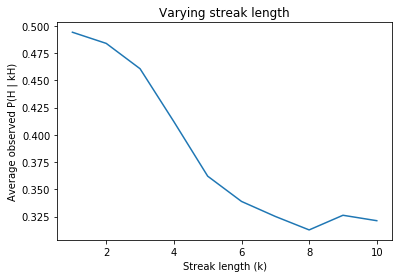

In [8]:
plt.plot([i for i in range(1, 11)], data0)
plt.title("Varying streak length")
plt.ylabel("Average observed P(H | kH)")
plt.xlabel("Streak length (k)")

In [7]:
k=3
data1 = []
for i in range(100):
    data1.append(get_expected(N=10+i, k=k, p=0.5))

In [8]:
k=3
data2 = []
for i in range(100):
    data2.append(get_expected(N=10+i, k=k, p=0.25))

In [9]:
k=3
data3 = []
for i in range(100):
    data3.append(get_expected(N=10+i, k=k, p=0.75))

Text(0,0.5,'Average observed P(H | 3H)')

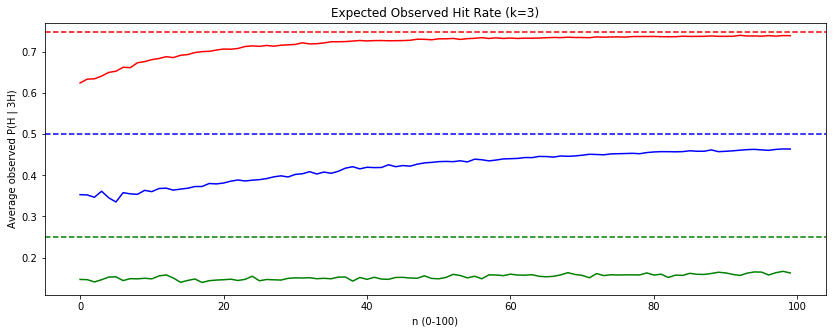

In [31]:
plt.figure(figsize=(14,5))
plt.plot(data1, color='b', label='p=0.75')
plt.axhline(y=0.5, ls='--', color='b')

plt.plot(data2, color='g')
plt.axhline(y=0.25, ls='--', color='g')

plt.plot(data3, color = 'r')
plt.axhline(y=0.75, ls='--', color='r')

plt.title("Expected Observed Hit Rate (k=3)");
plt.xlabel("n (0-100)")
plt.ylabel("Average observed P(H | 3H)")

## Streak Bias in GSW Data

In [2]:
def game_json_to_game_df(json_filename):
    with open(json_filename) as f:
        data = json.load(f)
    gameData = pd.DataFrame()
    gameData['player'] = data.keys()
    shots = []
    for i in data.values():
        made = ""
        for j in i:
            made+=(str(j))
        shots.append(made)
    gameData['shots'] = shots
    gameData['game'] = [str(json_filename)[10:22] for i in np.arange(len(data))]
    return gameData

In [3]:
datafile_path = Path('data/2017/201610250GSW.json')
student_output_201610250GSW = game_json_to_game_df(datafile_path)
student_output_201610250GSW.head(5)

,player,shots,game
0,A. Iguodala,001,201610250GSW
1,A. Varejao,01,201610250GSW
2,D. Bertans,11,201610250GSW
3,D. Dedmon,0010,201610250GSW
4,D. Green,0010011110100111,201610250GSW


In [4]:
data_dir = Path('data/2017')
games = list(data_dir.glob('**/*.json'))
unindexed_shot_data = pd.DataFrame()
for i in games:
     unindexed_shot_data = unindexed_shot_data.append(game_json_to_game_df(i), ignore_index = True)
shot_data = unindexed_shot_data.set_index(['game', 'player'])
shot_data.head(5)

shots
game         player                       
201610250GSW A. Iguodala               001
             A. Varejao                 01
             D. Bertans                 11
             D. Dedmon                0010
             D. Green     0010011110100111

In [5]:
klay_data = shot_data.loc[pd.IndexSlice[:, 'K. Thompson'], 'shots']
klay_data.head(5)

game          player     
201610250GSW  K. Thompson                0000010110101
201610280NOP  K. Thompson    0101011011100010001111111
201610300PHO  K. Thompson         00000111101001111000
201611010POR  K. Thompson          1011011010000010010
201611030GSW  K. Thompson              010010001100111
Name: shots, dtype: object

In [6]:
klay_data.tail(5)

game          player     
201706010GSW  K. Thompson        0100000100001000
201706040GSW  K. Thompson         011111100101011
201706070CLE  K. Thompson    11101111010010110110
201706090CLE  K. Thompson           0101100100100
201706120GSW  K. Thompson           1000000110001
Name: shots, dtype: object

In [7]:
def count_conditionally(shot_sequences, conditioning_set, event='1'):
    """
    shot_sequences: pd.Series (string) of shot strings for a set of games or a single string
       to be coerced into a pd.Series
    conditioning_set: string or regex pattern representing the conditioning set
    event: string or regex pattern representing the event of interest
    
    return: pd.Series of the number of times event occured after the
       conditioning set in each game
    """
    totals = []
    matches = []
    cond_len = len(conditioning_set)
    # loop through all the sequences
    for shot_sequence in shot_sequences:
        num_total = 0
        num_match = 0
        seq_len = len(shot_sequence)
        # loop through all starting locations for the condition
        for l in np.arange(seq_len - cond_len):
            mismatch = False
            # check if sequence starting at l matches the condition
            if shot_sequence[l:l+cond_len] == conditioning_set:
                num_total += 1
                # if it does - check if the following value matches the event
                if shot_sequence[l+cond_len] == event:
                    num_match += 1
        totals.append(num_total)
        matches.append(num_match)
    return pd.Series(totals), pd.Series(matches)

def count_makes(shot_sequences):
    total_shots = 0
    total_makes = 0
    for shot_sequence in shot_sequences:
        total_shots += len(shot_sequence)
        np_sequence = np.array([i for i in shot_sequence], dtype=int)
        total_makes += np.count_nonzero(np_sequence)
    return total_shots, total_makes

In [8]:
def get_bias_dicts(nshots=100, max_streak=5, probs=[.25, .5, .75]):
    num_probs = len(probs)
    B = [[None for column in range(num_probs)] for row in range(max_streak+1) ]
    for streak_length in range(1, max_streak+1):
        for i in range(num_probs):
            p_hit = probs[i]
            B[streak_length][i]=prop.outcome_and_frequency_dictionary(nshots,streak_length,p_hit)
    return B

In [9]:
klay_data

game          player     
201610250GSW  K. Thompson                0000010110101
201610280NOP  K. Thompson    0101011011100010001111111
201610300PHO  K. Thompson         00000111101001111000
201611010POR  K. Thompson          1011011010000010010
201611030GSW  K. Thompson              010010001100111
                                       ...            
201706010GSW  K. Thompson             0100000100001000
201706040GSW  K. Thompson              011111100101011
201706070CLE  K. Thompson         11101111010010110110
201706090CLE  K. Thompson                0101100100100
201706120GSW  K. Thompson                1000000110001
Name: shots, Length: 95, dtype: object

In [10]:
total, makes = count_makes(klay_data)
avg_pct = makes/total
print(avg_pct)

0.5093833780160858


In [11]:
def get_empirical(shot_sequences, k=2):
    conditioning_set_one = ''.join(str(int(e)) for e in np.ones(k))
    emp_totals, emp_makes = count_conditionally(shot_sequences, conditioning_set_one)
    return emp_totals, emp_makes

In [12]:
total_string = ""
for seq in klay_data:
    total_string += seq
print(len(total_string))

1865


In [13]:
kvals = [2, 3, 4]
observed_ps = []
for k in kvals:
    etot, emade = get_empirical([total_string], k=k)
    observed_ps.append(emade[0]/etot[0])
    
observed_difs = [e - avg_pct for e in observed_ps]

In [14]:
print(observed_ps)
print(observed_difs)

[0.5287128712871287, 0.5168539325842697, 0.5362318840579711]
[0.01932949327104294, 0.007470554568183907, 0.026848506041885267]


In [15]:
def get_biased(shot_sequences, ks=[2]):
    seq_biases = [[] for k in ks]
    for shot_sequence in shot_sequences:
        shot_len = len(shot_sequence)
        p = np.count_nonzero(np.array([i for i in shot_sequence], dtype=int))/shot_len
        
        B = get_bias_dicts(nshots=shot_len, max_streak=max(ks), probs=[p])
        for i in range(len(ks)):
            k = ks[i]
            bias = prop.expected_proportion(shot_len, k, B[k][0])
            seq_biases[i].append(bias)
    return [pd.Series(seq_bias) for seq_bias in seq_biases]

def get_lens(shot_sequences):
    return pd.Series([len(shot_sequence) for shot_sequence in shot_sequences])

In [16]:
def count_pos(ser):
    count = 0
    for s in ser:
        if s > 0:
            count += 1
            
    return count

In [17]:
ks = [2, 3, 4]

In [18]:
emp_totals2, emp_makes2 = get_empirical(klay_data, k=2)
emp_probs2 = emp_makes2/emp_totals2

In [19]:
emp_totals3, emp_makes3 = get_empirical(klay_data, k=3)
emp_probs3 = emp_makes3/emp_totals3

In [20]:
emp_totals4, emp_makes4 = get_empirical(klay_data, k=4)
emp_probs4 = emp_makes4/emp_totals4

In [21]:
biased_probs = get_biased(klay_data, ks=ks)
lens = get_lens(klay_data)

In [22]:
data = {"seq len": lens, "emp. total": emp_totals2, "emp. makes": emp_makes2, 
        "emp. prob": emp_probs2, "biased prob": biased_probs[0]}
df = pd.concat(data, axis=1)
df = df[~df.isin([np.inf, -np.inf]).any(1)]
df = df.dropna().reset_index(drop=True)
df['prob dif'] = df["emp. prob"] - df["biased prob"]
print(df)

    seq len  emp. total  emp. makes  emp. prob  biased prob  prob dif
0        13           1           0   0.000000     0.269336 -0.269336
1        25           8           6   0.750000     0.550019  0.199981
2        20           6           4   0.666667     0.356816  0.309850
3        19           2           0   0.000000     0.321427 -0.321427
4        15           2           1   0.500000     0.358173  0.141827
..      ...         ...         ...        ...          ...       ...
88       17           1           0   0.000000     0.247018 -0.247018
89       15           5           4   0.800000     0.597273  0.202727
90       20           7           3   0.428571     0.596502 -0.167930
91       13           1           0   0.000000     0.269336 -0.269336
92       13           1           0   0.000000     0.202023 -0.202023

[93 rows x 6 columns]


In [23]:
print(df['prob dif'].mean())

0.020424666538822054


In [24]:
count_pos(df['prob dif'])

53

In [25]:
data = {"seq len": lens, "emp. total": emp_totals3, "emp. makes": emp_makes3, 
        "emp. prob": emp_probs3, "biased prob": biased_probs[1]}
df = pd.concat(data, axis=1)
df = df[~df.isin([np.inf, -np.inf]).any(1)]
df = df.dropna().reset_index(drop=True)
df['prob dif'] = df["emp. prob"] - df["biased prob"]
print(df)

    seq len  emp. total  emp. makes  emp. prob  biased prob  prob dif
0        25           5           4   0.800000     0.495225  0.304775
1        20           4           2   0.500000     0.310248  0.189752
2        20           2           1   0.500000     0.417339  0.082661
3        13           5           4   0.800000     0.472058  0.327942
4        16           1           0   0.000000     0.420588 -0.420588
..      ...         ...         ...        ...          ...       ...
73       18           3           2   0.666667     0.484689  0.181978
74       11           1           0   0.000000     0.310646 -0.310646
75       15           1           0   0.000000     0.320901 -0.320901
76       15           4           3   0.750000     0.542525  0.207475
77       20           3           1   0.333333     0.542954 -0.209621

[78 rows x 6 columns]


In [26]:
print(df['prob dif'].mean())

-0.027307128496663457


In [27]:
count_pos(df['prob dif'])

39

In [28]:
data = {"seq len": lens, "emp. total": emp_totals4, "emp. makes": emp_makes4, 
        "emp. prob": emp_probs4, "biased prob": biased_probs[2]}
df = pd.concat(data, axis=1)
df = df[~df.isin([np.inf, -np.inf]).any(1)]
df = df.dropna().reset_index(drop=True)
df['prob dif'] = df["emp. prob"] - df["biased prob"]
print(df)

    seq len  emp. total  emp. makes  emp. prob  biased prob  prob dif
0        25           3           3   1.000000     0.451362  0.548638
1        20           2           0   0.000000     0.293818 -0.293818
2        20           1           0   0.000000     0.387729 -0.387729
3        13           4           3   0.750000     0.452068  0.297932
4        21           1           0   0.000000     0.525774 -0.525774
5        22           3           1   0.333333     0.434913 -0.101579
6        23           5           4   0.800000     0.512514  0.287486
7        18           3           2   0.666667     0.590494  0.076173
8        44           6           2   0.333333     0.639210 -0.305877
9        23           2           2   1.000000     0.407516  0.592484
10       25           1           0   0.000000     0.451362 -0.451362
11       18           1           0   0.000000     0.451251 -0.451251
12       13           2           1   0.500000     0.452068  0.047932
13       18         

In [29]:
print(df['prob dif'].mean())

-0.020313980871721305


In [30]:
count_pos(df['prob dif'])

26